# 如何将RAW数据转换为最终我们看到的RGB图像

Hawk Wang

这里我将展示**Python**是一个图像处理的好工具，我将用它来构建一个非常基础的相机内图像处理的流水线(除了没有高级的去噪和颜色转换)，这个流水线可以将原始的RAW格式图片转换为人眼可看的RGB图像并保存为最终的JPEG图像。

要进行图像处理，首先我会引入以下一些python package:

- **Image**: 用于读取RAW图像原始数据
- **numpy**: 用于用矩阵形式来管理图像
- **matplotlib**: 用于可视化数据


In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
%matplotlib inline

### 1. 读取图像做基本分析

下面这个函数读取了附件的banana_slug.tiff这个文件，并显示了此图像的一些基本信息。

In [9]:
def loadImg(rawImgPath):
    img = imread(rawImgPath)
#     img = img.astype(np.float64)    
    if len(img.shape)>2:
        img = img[:,:,-1]
    return img
    
img = loadImg('./data/banana_slug.tiff')
print('The image height is %d, width is %d'%(img.shape[0], img.shape[1]), ', and each image data item occupies %d bits'%(8*img.itemsize))
print('After converting, the image data type is', img.dtype)
img = img.astype(np.float64)

The image height is 2856, width is 4290 , and each image data item occupies 16 bits
After converting, the image data type is uint16


如上面所显示，此图像大小是4290x2856(宽x高)，每个像素占用16bit, 为了便于处理在上面基本信息显示后，我将图像转换为了64bit的浮点类型。

下面用matplotlib显示了图像，以及图像的直方图。我们可以看到此图像非常黑，如果仔细看的话还会发现有很多格子状的细节。而它的直方图可以看出其像素的取值范围从约2000到大约14000都有，但是大部分像素集中在从2000到6000的范围内，这也说明了图像为什么这么黑。

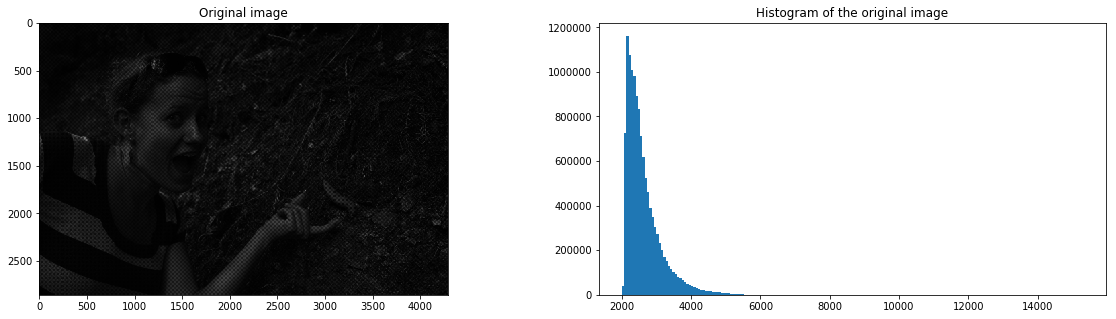

In [10]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.hist(img.flatten(), bins=200)
plt.title('Histogram of the original image')
plt.show()

### 2. Linearization

In [5]:
print("The min/max value of image data is (%.0f, %.0f)"%(img.min(), img.max()))

The min/max value of image data is (2002, 15303)


为了更加精确的审视图像，我用min()和max()操作读取了图像像素的最小值和最大值，它们分别是2002和15303. 正如我在讲义中提到，相机的传感器有它自身的响应函数，此函数在光电二极管的势阱饱和（过曝）或者光线过暗（噪声淹没了信号）时，它将不再是线性的。因此让我们截取图像中的某一段，例如像素值为2047到15000的部分，而其他的部分如果像素值小于2047则设置为2047，像素值高于15000则设置为15000，并将结果线性缩放到0到1之间：

In [11]:
def linearize(img, minValue, maxValue):
    """
    Returns the linearized image, with specified min/max limit value.
    Parameters
    ----------
    img : original image
    minValue: specified min value, pixels lower/equal than minValue will be mapped to 0
    maxValue: specified min value, pixels larger/equal than maxValue will be mapped to 1

    Returns
    -------
    linearized image with pixel value within the range [0, 1]
    """
    ret=(img - minValue)/(maxValue - minValue)
    ret[ret<0] =0
    ret[ret>1] =1
    
    return ret
    
imgLin = linearize(img, 2047, 15000)

线性化后，图像从视觉上并没有特别大的差异，但是直方图已经有所不同了

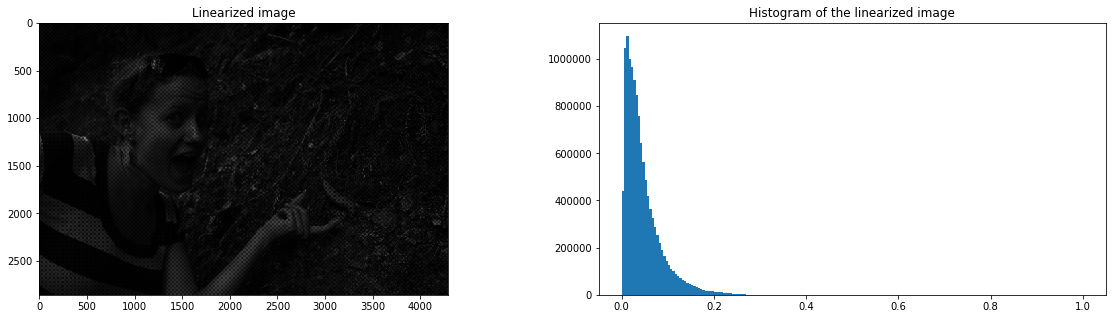

In [13]:
fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title('Linearized image')
plt.imshow(imgLin, cmap="gray")
plt.subplot(1,2,2)
plt.hist(imgLin.flatten(), bins=200)
plt.title('Histogram of the linearized image')
plt.show()

### 3. 确定正确的Bayer格式

正如讲义中所讲，RAW格式图片都是以Bayer形式存储的，常见的Bayer格式有四种，如下图所示：

![PossibleBayerPatterns](imgs/bayerPatterns.jpg)
<br><center><bold>Figure: From left to right: ’grbg’, ’rggb’, ’bggr’, ’gbrg’.</bold></center>


在处理RAW格式图片时，有一个很好的工具叫做**dcraw**可以帮助我们确定到底采用的是哪种格式，只需要用如下命令即可。可以看到它的Bayer格式是RG/GB

```
dcraw -i -v banana_slug.cr2
```

```
Filename: data/banana_slug.cr2
Timestamp: Mon May 27 09:29:22 2013
Camera: Canon EOS REBEL T3
ISO speed: 400
Shutter: 1/197.4 sec
Aperture: f/4.0
Focal length: 24.0 mm
Embedded ICC profile: no
Number of raw images: 1
Thumb size:  4272 x 2848
Full size:   4352 x 2874
Image size:  4290 x 2856
Output size: 4290 x 2856
Raw colors: 3
Filter pattern: RG/GB
Daylight multipliers: 2.353782 0.931874 1.178846
Camera multipliers: 2056.000000 1024.000000 1697.000000 1024.000000
```

dcraw是跨平台的，其官网是http://www.cybercom.net/~dcoffin/dcraw/ ， 读者可以登录上去看看如何在自己的平台上安装。

### 4. 白平衡

为了能够做白平衡，根据讲义中提到的公式，需要将原始数据分离为R/G/B三个通道。有很多方法可以做到这点，而我这里借用了https://github.com/colour-science/colour-demosaicing, 这里有一个**masks_CFA_Bayer**函数可以很方便的得到一个掩模图像，用于得到任意的通道。

In [18]:
def masks_CFA_Bayer(shape, pattern='RGGB'):
    """
    Returns the *Bayer* CFA red, green and blue masks for given pattern.
    Parameters
    ----------
    shape : array_like
        Dimensions of the *Bayer* CFA.
    pattern : unicode, optional
        **{'RGGB', 'BGGR', 'GRBG', 'GBRG'}**,
        Arrangement of the colour filters on the pixel array.
    Returns
    -------
    tuple
        *Bayer* CFA red, green and blue masks.
    Examples
    --------
    >>> from pprint import pprint
    >>> shape = (3, 3)
    >>> pprint(masks_CFA_Bayer(shape))
    (array([[ True, False,  True],
           [False, False, False],
           [ True, False,  True]], dtype=bool),
     array([[False,  True, False],
           [ True, False,  True],
           [False,  True, False]], dtype=bool),
     array([[False, False, False],
           [False,  True, False],
           [False, False, False]], dtype=bool))
    >>> pprint(masks_CFA_Bayer(shape, 'BGGR'))
    (array([[False, False, False],
           [False,  True, False],
           [False, False, False]], dtype=bool),
     array([[False,  True, False],
           [ True, False,  True],
           [False,  True, False]], dtype=bool),
     array([[ True, False,  True],
           [False, False, False],
           [ True, False,  True]], dtype=bool))
    """

    pattern = pattern.upper()

    channels = dict((channel, np.zeros(shape)) for channel in 'RGB')
    for channel, (y, x) in zip(pattern, [(0, 0), (0, 1), (1, 0), (1, 1)]):
        channels[channel][y::2, x::2] = 1

    return tuple(channels[c] for c in 'RGB')

cfaMask = masks_CFA_Bayer(imgLin.shape, pattern='RGGB')

掩模图像可以显示出来，这里只显示了部分

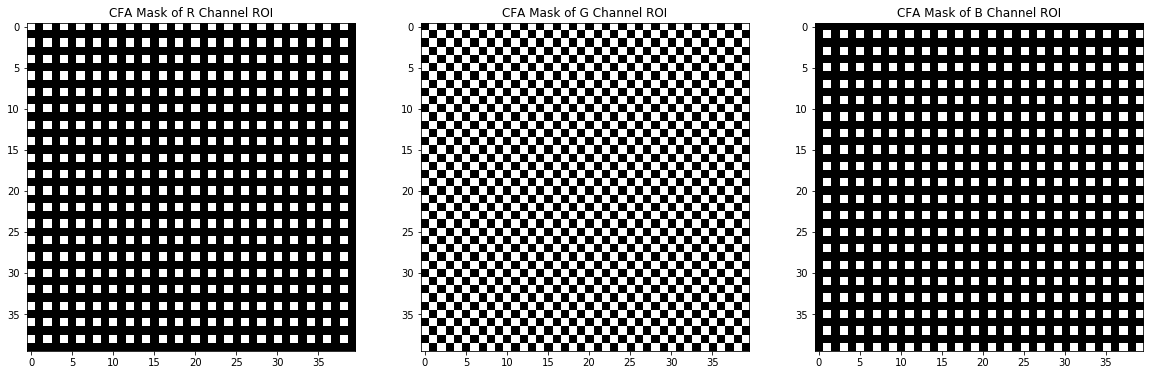

In [19]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(cfaMask[0][0:40,0:40], cmap="gray")
plt.title('CFA Mask of R Channel ROI')
plt.subplot(1,3,2)
plt.imshow(cfaMask[1][0:40,0:40], cmap="gray")
plt.title('CFA Mask of G Channel ROI')
plt.subplot(1,3,3)
plt.imshow(cfaMask[2][0:40,0:40], cmap="gray")
plt.title('CFA Mask of B Channel ROI')
plt.show()

### 4.1 白平衡算法：灰世界法

In [28]:
def greyWorldWB(imgIn, cfaMask):
    """
    Implement the grey world white balancing algorithm.
    
    Parameters
    ----------
    imgIn : original image within range [0, 1]
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns
    -------
    White balanced image.
    """

    channels = [imgIn * mask for mask in cfaMask]
    channelSums = [im.sum() for im in channels]
    channelCounts = [mask.sum() for mask in cfaMask]
    rgbMeans = [channelSums[i] / channelCounts[i] for i in range(3)]

    rIn, gIn, bIn = channels
    rOut = rgbMeans[1] / rgbMeans[0] * rIn
    gOut = gIn
    bOut = rgbMeans[1] / rgbMeans[2] * bIn

    imgOut = rOut * cfaMask[0] + gOut * cfaMask[1] + bOut * cfaMask[2]

    return imgOut

### 4.2 白平衡法：白世界法

In [29]:
def whiteWorldWB(imgIn, cfaMask):
    """
    Implement the white world white balancing algorithm.
    
    Parameters
    ----------
    imgIn : original image within range [0, 1]
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns
    -------
    White balanced image.
    """

    channels = [imgIn * mask for mask in cfaMask]
    rgbMax = [c.max() for c in channels]

    rIn, gIn, bIn = channels
    rOut = rgbMax[1] / rgbMax[0] * rIn
    gOut = gIn
    bOut = rgbMax[1] / rgbMax[2] * bIn

    imgOut = rOut * cfaMask[0] + gOut * cfaMask[1] + bOut * cfaMask[2]

    return imgOut

### 4.3 比较上述两种方法

让我们来比较上述两种算法。可以看出，白世界法更简洁，而且可以保持原始图像的值域。当然也可以看出，白世界法会导致图像中出现一些格子状的条纹效应，当前暂时忽略之。

In [33]:
imgWBGrayWorld = greyWorldWB(imgLin, cfaMask)
imgWBWhiteWorld = whiteWorldWB(imgLin, cfaMask)
print("min/max value of imgWBGrayWorld and imgWBWhiteWorld: (%f, %f) (%f, %f)"%(imgWBGrayWorld.min(), imgWBGrayWorld.max(), imgWBWhiteWorld.min(), imgWBWhiteWorld.max()))

min/max value of imgWBGrayWorld and imgWBWhiteWorld: (0.000000, 1.144043) (0.000000, 1.000000)


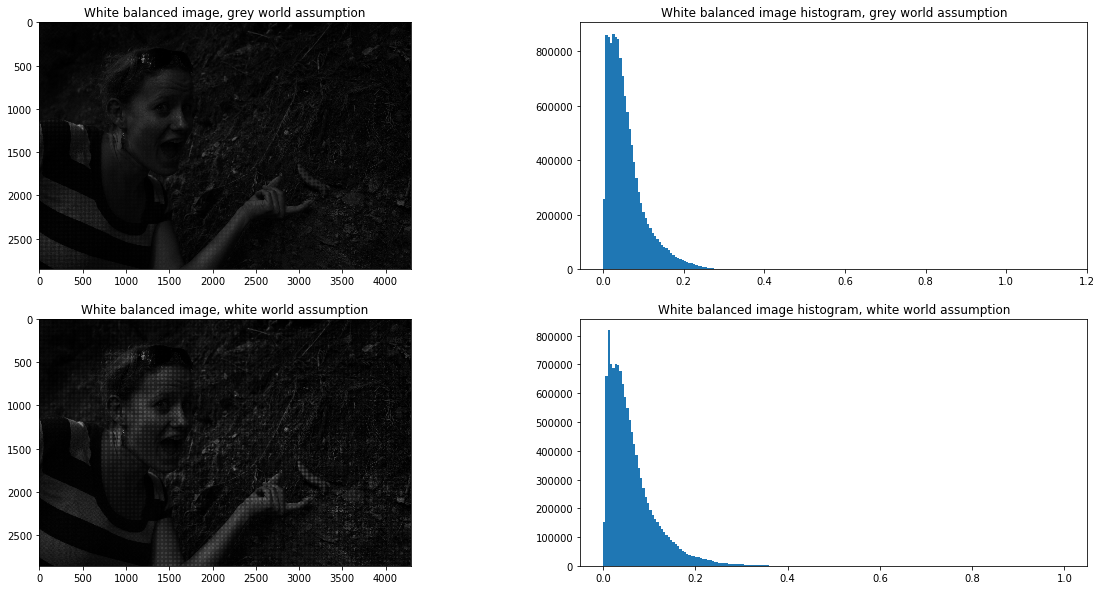

In [35]:
fig=plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('White balanced image, grey world assumption')
plt.imshow(imgWBGrayWorld,cmap="gray")
plt.subplot(2,2,2)
plt.hist(imgWBGrayWorld.flatten(), bins=200)
plt.title('White balanced image histogram, grey world assumption')
plt.subplot(2,2,3)
plt.imshow(imgWBWhiteWorld,cmap="gray")
plt.title('White balanced image, white world assumption')
plt.subplot(2,2,4)
plt.hist(imgWBWhiteWorld.flatten(), bins=200)
plt.title('White balanced image histogram, white world assumption')
plt.show()

### 5. 去马赛克

目前得到的图像依然是Bayer格式的，根据讲义所述我们需要将其分离成RGB三个通道，并且通过插值来填补每个通道确实的值，才能形成彩色图像。有很多方法来实现这一点，这里实现了两种方法，一种是插值，一种是卷积，这里卷积的代码也是借鉴于https://github.com/colour-science/colour-demosaicing

我比较了两种方法作用在两种不同的白平衡算法输出结果上的差异：

In [36]:
from scipy.ndimage.filters import convolve
def demosaicing_by_Conv(imgIn, cfaMask):   
    """
    Implement the demosaicing algorithm by convolution.
    
    Parameters
    ----------
    imgIn : original image, might have been white balanced
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns        
    -------
    RGB image after demosaicing
    """
    
    H_G = np.asarray(
        [[0, 1, 0],
         [1, 4, 1],
         [0, 1, 0]]) / 4  

    H_RB = np.asarray(
        [[1, 2, 1],
         [2, 4, 2],
         [1, 2, 1]]) / 4  

    rIn, gIn, bIn = [imgIn * mask for mask in cfaMask]
    rOut = convolve(rIn, H_RB)
    gOut = convolve(gIn, H_G)
    bOut = convolve(bIn, H_RB)
    
    ret = np.stack((rOut, gOut, bOut), axis=2)    
    return ret

In [37]:
from scipy.interpolate import RectBivariateSpline, interp2d
def demosaicing_by_interp(imgIn, cfaMask):
    """
    Implement the demosaicing algorithm by interpolation.
    
    Parameters
    ----------
    imgIn : original image, might have been white balanced
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.

    Returns        
    -------
    RGB image after demosaicing
    """
    
    channels = [imgIn * mask for mask in cfaMask]
    H, W = imgIn.shape[0:2]
    #interpolate the R channel
    yPos, xPos=np.meshgrid(np.arange(0,H,2), np.arange(0,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(0,W,2), np.arange(0,H,2), imgVal)
    newR = interObj(np.arange(0,W,1), np.arange(0,H,1))
    
    #interpolate the B channel
    yPos, xPos=np.meshgrid(np.arange(1,H,2), np.arange(1,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(1,W,2), np.arange(1,H,2), imgVal)
    newB = interObj(np.arange(0,W,1), np.arange(0,H,1))
    
    yPos, xPos=np.meshgrid(np.arange(0,H,2), np.arange(1,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(1,W,2), np.arange(0,H,2), imgVal)
    newG1 = interObj(np.arange(0,W,1), np.arange(0,H,1))
    yPos, xPos=np.meshgrid(np.arange(0,H,2), np.arange(1,W,2), indexing='ij')
    imgVal = imgIn[yPos, xPos]
    interObj = interp2d(np.arange(1,W,2), np.arange(0,H,2), imgVal)
    newG2 = interObj(np.arange(0,W,1), np.arange(0,H,1))
    newG = (newG1 + newG2)/2

    ret = np.stack((newR, newG, newB), axis=2)
    return ret

imgGWDMSConv = demosaicing_by_Conv(imgWBGrayWorld, cfaMask)
imgGWDMSInterp = demosaicing_by_interp(imgWBGrayWorld, cfaMask)
imgWWDMSConv = demosaicing_by_Conv(imgWBWhiteWorld, cfaMask)
imgWWDMSInterp = demosaicing_by_interp(imgWBWhiteWorld, cfaMask)

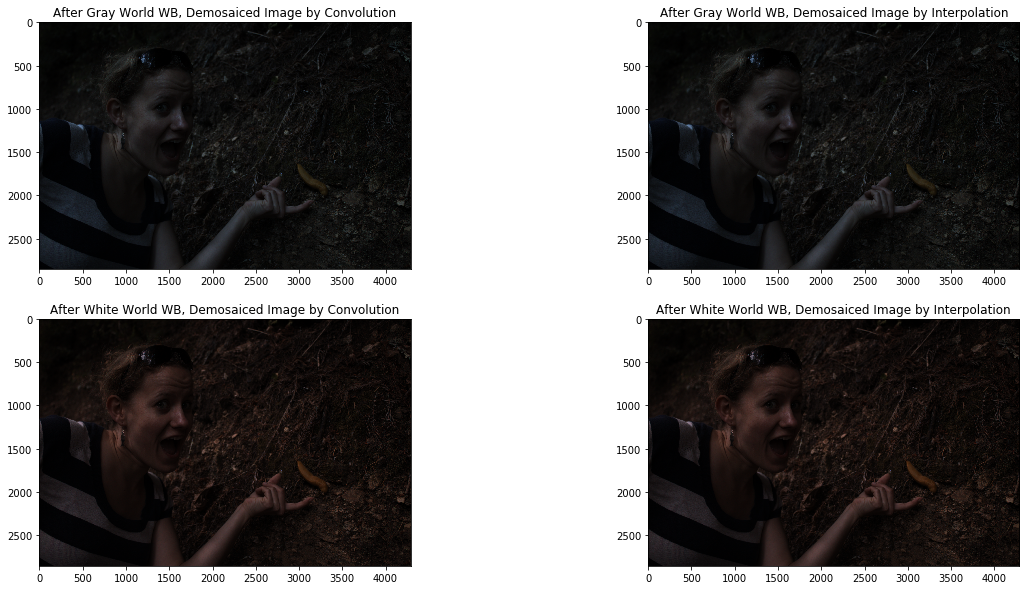

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(imgGWDMSConv)
plt.title('After Gray World WB, Demosaiced Image by Convolution')
plt.subplot(2,2,2)
plt.imshow(imgGWDMSInterp)
plt.title('After Gray World WB, Demosaiced Image by Interpolation')
plt.subplot(2,2,3)
plt.imshow(imgWWDMSConv)
plt.title('After White World WB, Demosaiced Image by Convolution')
plt.subplot(2,2,4)
plt.imshow(imgWWDMSInterp)
plt.title('After White World WB, Demosaiced Image by Interpolation')
plt.show()

可以看出插值和卷积的结果几乎一致，但卷积法显然要简单很多。因此后面的结果都是构建在卷积法的基础上的。

### 6. 亮度修正和Gamma校正

图像的亮度修正比较简单，就是线性乘以一个比例因子。但这里要注意的是：必须将图像的值限定在[0,1]之间，否则就会在最终图像中出现过曝，对于当前这张图像，我选择了亮度放大3倍

In [41]:
from skimage.color import rgb2gray, rgb2grey
def scaleImg(imgIn, sv=3):
    """
    Scale the image.
    
    Here we get the max value of gray image converted by imgIn,
    and use this value to get the scale value. 
    
    Parameters
    ----------
    imgIn : original image after demosaicing.
    sv:  a const value to adjust the scale value.
    
    Returns        
    -------
    Scaled image.
    """
    grayImg = rgb2gray(imgIn)
    scale = sv / grayImg.max()
    outImg = imgIn.copy()
    outImg *= scale
    outImg[outImg>1]=1 #Limit the max value to 1 to prevent from over exposure
    return outImg

imgGWScaled = scaleImg(imgGWDMSConv)
imgWWScaled = scaleImg(imgWWDMSConv)

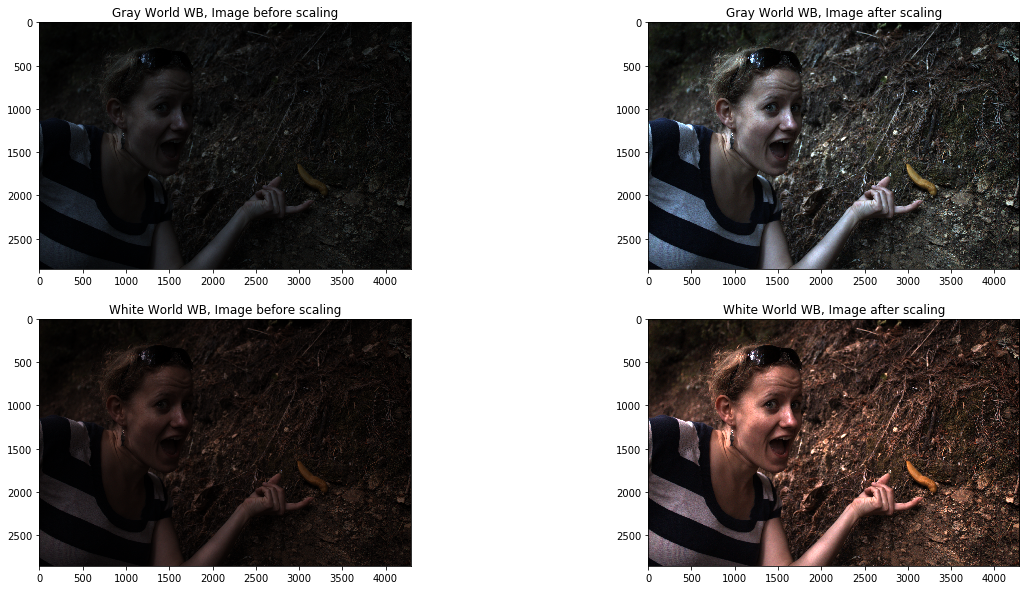

In [42]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(imgGWDMSConv)
plt.title("Gray World WB, Image before scaling")
plt.subplot(2,2,2)
plt.imshow(imgGWScaled)
plt.title("Gray World WB, Image after scaling")

plt.subplot(2,2,3)
plt.imshow(imgWWDMSConv)
plt.title("White World WB, Image before scaling")
plt.subplot(2,2,4)
plt.imshow(imgWWScaled)
plt.title("White World WB, Image after scaling")

plt.show()

我们还可以进一步对图像进行Gamma校正来适应人眼的感觉，下面是一个典型的Gamma校正公式，这一步也叫做Tone Mapping

** $$C_{nonlinear}=\begin{cases}12.92*C_{linear} & \text { if }C_{linear}<=0.0031308 \\ (1+0.055)*C_{linear}^{\frac{1}{2.4}} & \text { if }C_{linear}>0.0031308  \end{cases}$$ **

通过下面的输出图像比较，可以很明显看出经过Tone Mapping后图像显得更加清晰更亮了，细节也凸显出来了。

In [43]:
def gammaCorr(imgIn):
    """
    Scale the image.
    
    Here we get the max value of gray image converted by imgIn,
    and use this value to get the scale value. 
    
    Parameters
    ----------
    imgIn : original image after demosaicing.
    sv:  a const value to adjust the scale value.
    
    Returns        
    -------
    Scaled image.
    """    
    imgOut = imgIn.copy() 
    isDarkPixel=imgIn<=0.0031308
    isBrightPixel=np.logical_not(isDarkPixel)
    imgOut[isDarkPixel]*=12.92
    imgOut[isBrightPixel] = (1+0.055)*(imgIn[isBrightPixel])**(1/2.4) - 0.055

    return imgOut

outImgGW = gammaCorr(imgGWScaled)
outImgWW = gammaCorr(imgWWScaled)

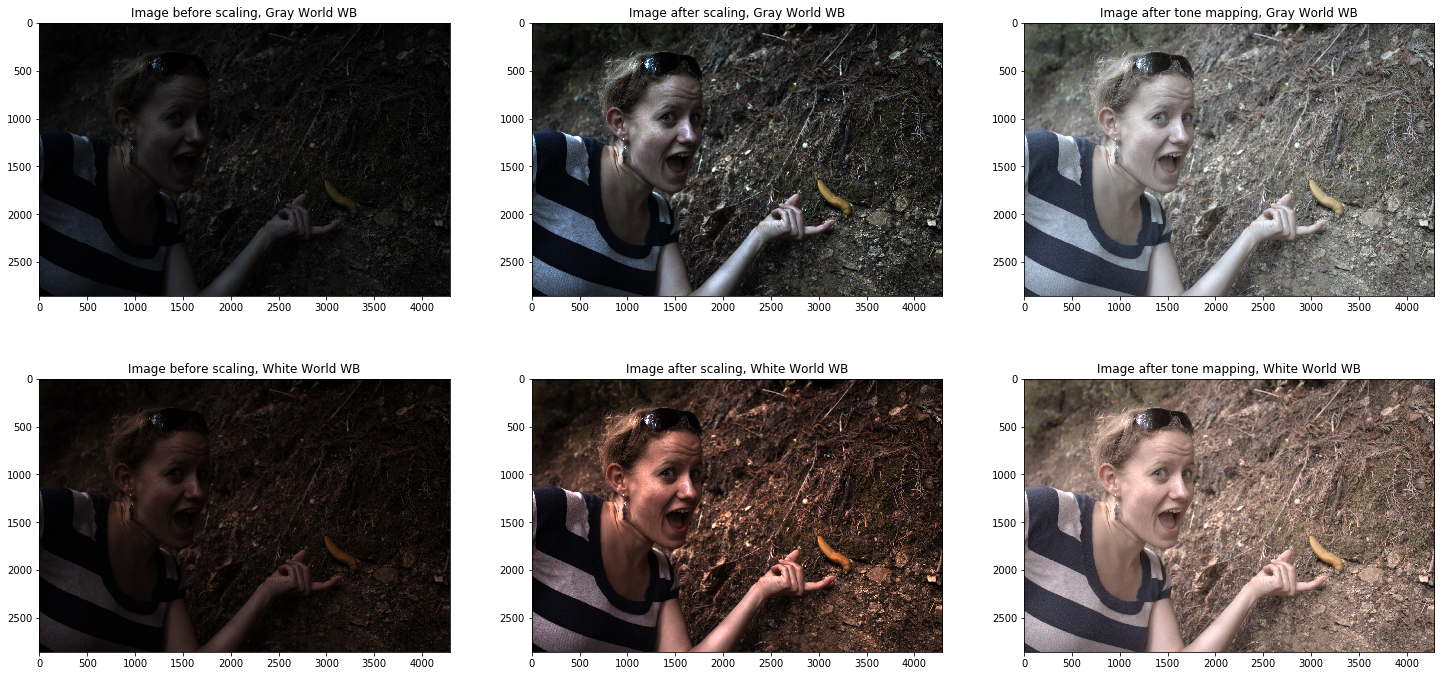

In [44]:
plt.figure(figsize=(25,12))
plt.subplot(2,3,1)
plt.imshow(imgGWDMSInterp)
plt.title("Image before scaling, Gray World WB")
plt.subplot(2,3,2)
plt.imshow(imgGWScaled)
plt.title("Image after scaling, Gray World WB")
plt.subplot(2,3,3)
plt.imshow(outImgGW)
plt.title("Image after tone mapping, Gray World WB")
plt.subplot(2,3,4)
plt.imshow(imgWWDMSInterp)
plt.title("Image before scaling, White World WB")
plt.subplot(2,3,5)
plt.imshow(imgWWScaled)
plt.title("Image after scaling, White World WB")
plt.subplot(2,3,6)
plt.imshow(outImgWW)
plt.title("Image after tone mapping, White World WB")
plt.show()

### 7. 压缩和存储图像

这里我直接采用了OpenCV来压缩和存储图像

In [45]:
import cv2
def saveImg(pureName, img):
    storeImg=(img * 255/img.max()).astype(np.uint8)
    storeImg=cv2.cvtColor(storeImg, cv2.COLOR_RGB2BGR)
    ret=cv2.imwrite("%s.png"%pureName, storeImg)
    ret=cv2.imwrite("%s.jpg"%pureName, storeImg, (cv2.IMWRITE_JPEG_QUALITY,95))
    
saveImg("storeImgGW", outImgGW)
saveImg("storeImgWW", outImgWW)

### 8. 集成上述所有函数

上面的所有代码，我都写成了函数形式，所以这里可以将它们组合为一个单一的转换函数raw2rgb，使得可以一步完成所有操作：

In [47]:
def raw2rgb(rawImgPath, scale=3, lowLimit=2047, highLimit=15000):
    rawImg = loadImg(rawImgPath)
    imgLinear = linearize(rawImg, lowLimit, highLimit)    
    cfaMask = masks_CFA_Bayer(imgLinear.shape, pattern='RGGB')
    imgWBGrayWorld = greyWorldWB(imgLinear, cfaMask)
    imgGWDMSInterp = demosaicing_by_interp(imgWBGrayWorld, cfaMask)
    imgGWScaled = scaleImg(imgGWDMSInterp, sv=scale)
    outImgGW = gammaCorr(imgGWScaled)
    
    return outImgGW
    
outImgGW = raw2rgb('./data/banana_slug.tiff')    
saveImg("storeImgGW", outImgGW)    

### 9. Perform manual white balancing

上面的图像总感觉颜色还不够好，灰世界法的输出过于偏白偏冷色调，白世界法的又偏黄。这是因为我们是用图像的全局值(平均值或者最大值)来做白平衡的基准。为了将白平衡做得更好，可以考虑采用人为指定图像**白色区域**来源的方法：

1. 选择图像中的某些你认为真实对象是白色的块

2. 用这些块的信息作为白平衡的基准。

我用下面的代码来选择了几个块并可视化了它们

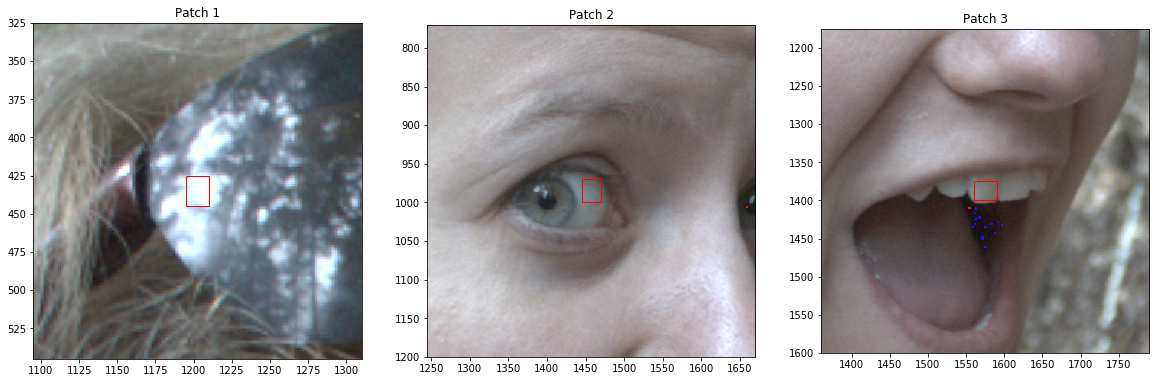

In [48]:
def showROI(img, roiList):    
    imgToShow = outImgGW.copy()
    plt.figure(figsize=(20,10))
    subplotsNum=1
    for roi in roiList:
        ax = plt.subplot(1, len(roiList), subplotsNum)
        top, bottom, left, right, extend = roi
        rect = plt.Rectangle([left, top], right-left, bottom-top, edgecolor='Red', facecolor='None')
        plt.imshow(imgToShow)
        plt.ylim(bottom+extend, top-extend)
        plt.xlim(left-extend, right+extend)
        plt.title("Patch %d"%subplotsNum)
        ax.add_patch(rect)
        subplotsNum+=1
    plt.show()
    
roi1=(425, 445, 1195, 1210, 100)
roi2=(970, 1000, 1445, 1470, 200)
roi3=(1375, 1400, 1560, 1590, 200)
roiList=[roi1, roi2, roi3]
showROI(outImgGW, roiList)    

In [50]:
def greyWorldWBByPatch(imgIn, cfaMask, roi):
    """
    Implement the patch based grey world white balancing algorithm.
    
    Parameters
    ----------
    imgIn : original image within range [0, 1]
    cfaMask: tuple, *Bayer* CFA red, green and blue masks.
    top,bottom,left,right: the image white patch corner position

    Returns
    -------
    White balanced image.
    """
    top, bottom, left, right, extend = roi
    channels = [imgIn * mask for mask in cfaMask]
    
    channelSums = [im[top:bottom, left:right].sum() for im in channels]
    channelCounts = [mask[top:bottom, left:right].sum() for mask in cfaMask]
    
    rgbMeans = [channelSums[i] / channelCounts[i] for i in range(3)]

    rIn, gIn, bIn = channels
    rOut = rgbMeans[1] / rgbMeans[0] * rIn
    gOut = gIn
    bOut = rgbMeans[1] / rgbMeans[2] * bIn

    imgOut = rOut * cfaMask[0] + gOut * cfaMask[1] + bOut * cfaMask[2]

    return imgOut

def raw2rgbPatch(rawImgPath, roi, scale=3, lowLimit=2047, highLimit=15000):
    rawImg = loadImg(rawImgPath)
    imgLinear = linearize(rawImg, lowLimit, highLimit)
    cfaMask = masks_CFA_Bayer(imgLinear.shape, pattern='RGGB')
    imgWBGrayWorld = greyWorldWBByPatch(imgLinear, cfaMask, roi)
    imgGWDMSInterp = demosaicing_by_interp(imgWBGrayWorld, cfaMask)
    imgGWScaled = scaleImg(imgGWDMSInterp, scale)
    outImgGW = gammaCorr(imgGWScaled)
    
    return outImgGW

outImgGWROI1 = raw2rgbPatch('./data/banana_slug.tiff', roi1)
outImgGWROI2 = raw2rgbPatch('./data/banana_slug.tiff', roi2)
outImgGWROI3 = raw2rgbPatch('./data/banana_slug.tiff', roi3)

上面的函数则实现了用特定的块来进行灰世界白平衡操作，我还用它来替换了原有的白平衡法，并整合成了新的一体化函数**raw2rgbPatch**，以下可以看出patch 2的效果是最好的：


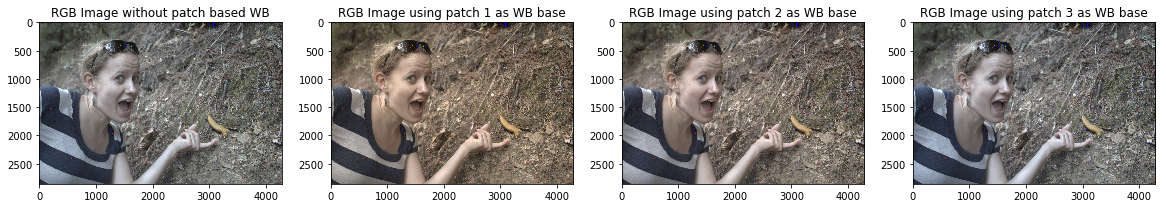

In [51]:
plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(outImgGW)
plt.title("RGB Image without patch based WB")
plt.subplot(1,4,2)
plt.imshow(outImgGWROI1)
plt.title("RGB Image using patch 1 as WB base")
plt.subplot(1,4,3)
plt.imshow(outImgGWROI2)
plt.title("RGB Image using patch 2 as WB base")
plt.subplot(1,4,4)
plt.imshow(outImgGWROI3)
plt.title("RGB Image using patch 3 as WB base")
plt.show()

saveImg("storeImgGWROI2", outImgGWROI2) 

### 10. 总结并测试其他图像

这个Notebook展示了相机内的基本图像处理，使得可以将RAW格式图片转换为RGB图片并保存为JPEG图像，上述的过程还写成了一个单一的函数**raw2rgbPatch**, 我从https://www.kenrockwell.com/leica/m9/sample-photos-3.htm 下载了一个新的RAW图像, 其格式是**DNG**. 我先用dcraw将其转换为了单通道的TIFF数据，然后用我们缩写的函数来处理之，可以看到图像被正确的被展示和保存。

```
dcraw -4 -D -T ./data/myraw/L1004220.DNG
```

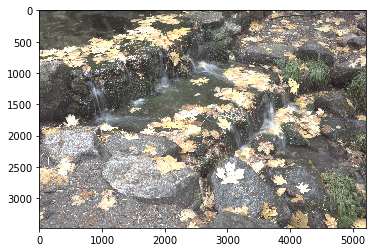

In [52]:
roi=(840,880,2600,2650,50)
outImgGW = raw2rgbPatch('./data/myraw/L1004220.tiff', roi, scale=2, lowLimit=20, highLimit=6000)
plt.imshow(outImgGW)
plt.show()
saveImg("L1004220_Hawk", outImgGW)    